In [42]:
import os


os.environ["CUDA_VISIBLE_DEVICES"]="1"
import os.path as osp
import json
from tqdm import  tqdm
import sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


sys.path.append('/data/Hszhu/Reggio')
# from simple_lama_inpainting import SimpleLama
# from lama import lama_with_refine
from src.demo.model import FreeFinePipeline
import torch
import cv2
import argparse
from src.utils.attention import AttentionStore,register_attention_control,Attention_Modulator,register_attention_control_4bggen,register_attention_control_compose
import clip
from diffusers import StableDiffusionPipeline, DDIMInverseScheduler, AutoencoderKL, DDIMScheduler,DDIMPipeline,StableDiffusionInpaintPipeline,UNet2DConditionModel
def temp_view_img(image: Image.Image, title: str = None) -> None:
    # PIL -> ndarray OR ndarray->PIL->ndarray
    if not isinstance(image, Image.Image):  # ndarray
        # image_array = Image.fromarray(image).convert('RGB')
        image_array = image
    else:  # PIL
        if image.mode != 'RGB':
            image.convert('RGB')
        image_array = np.array(image)

    plt.imshow(image_array)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()
def visualize_rgb_image(image: Image.Image, title: str = None) -> None:
    """
    Visualize an RGB image from a PIL Image format with an optional title.

    Parameters:
    image (PIL.Image.Image): The RGB image represented as a PIL Image.
    title (str, optional): The title to display above the image.

    Raises:
    ValueError: If the input is not a PIL Image or is not in RGB mode.
    """
    if not isinstance(image, Image.Image):
        raise ValueError("Input must be a PIL Image.")
    if image.mode != 'RGB':
        raise ValueError("Input image must be in RGB mode.")

    image_array = np.array(image)

    plt.imshow(image_array)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()
def temp_view( mask, title='Mask', name=None):
    """
    显示输入的mask图像

    参数:
    mask (torch.Tensor): 要显示的mask图像，类型应为torch.bool或torch.float32
    title (str): 图像标题
    """
    # 确保输入的mask是float类型以便于显示
    if isinstance(mask, np.ndarray):
        mask_new = mask
    else:
        mask_new = mask.float()
        mask_new = mask_new.detach().cpu()
        mask_new = mask_new.numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(mask_new, cmap='gray')
    plt.title(title)
    plt.axis('off')  # 去掉坐标轴
    # plt.savefig(name+'.png')
    plt.show()
def replace_mask(mask,src_mask_path):
    # 保存mask到ins子文件夹中
    cv2.imwrite(src_mask_path, mask.astype(np.uint8) * 255)
    print(f"Saved mask to {src_mask_path}")
    return src_mask_path
def save_mask(mask, dst_dir, da_name, ins_name,sample_id):
    da_name = str(da_name)
    ins_name = str(ins_name)
    sample_id = str(sample_id)
    # 创建da子文件夹
    subfolder_path = os.path.join(dst_dir, da_name)
    os.makedirs(subfolder_path, exist_ok=True)

    # 创建ins子文件夹
    ins_subfolder_path = os.path.join(subfolder_path, ins_name)
    os.makedirs(ins_subfolder_path, exist_ok=True)

    # 保存mask到ins子文件夹中
    mask_path = os.path.join(ins_subfolder_path, f"{sample_id}.png")
    cv2.imwrite(mask_path, mask.astype(np.uint8)*255)
    print(f"Saved mask to {mask_path}")

    return mask_path
def save_img(img, dst_dir, da_name, ins_name,sample_id):
    da_name = str(da_name)
    ins_name = str(ins_name)
    sample_id = str(sample_id)
    # 创建da子文件夹
    subfolder_path = os.path.join(dst_dir, da_name)
    os.makedirs(subfolder_path, exist_ok=True)

    # 创建ins子文件夹
    ins_subfolder_path = os.path.join(subfolder_path, ins_name)
    os.makedirs(ins_subfolder_path, exist_ok=True)

    # 保存img到ins子文件夹中
    img_path = os.path.join(ins_subfolder_path, f"{sample_id}.png")
    cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    print(f"Saved image to {img_path}")

    return img_path

def save_json(data_dict, file_path):
    """
    将字典保存为 JSON 文件

    Args:
        data_dict (dict): 需要保存的字典
        file_path (str): JSON 文件的保存路径
    """
    with open(file_path, 'w', encoding='utf-8') as json_file:
        json.dump(data_dict, json_file, ensure_ascii=False, indent=4)
def save_masks(masks, dst_dir, da_name):
    # 创建子文件夹
    subfolder_path = os.path.join(dst_dir, da_name)
    os.makedirs(subfolder_path, exist_ok=True)

    # 用于存储保存的mask路径
    mask_paths = []

    # 保存每个mask到子文件夹中
    for idx, mask in enumerate(masks):
        mask_path = os.path.join(subfolder_path, f"mask_{idx + 1}.png")
        cv2.imwrite(mask_path, mask)  # 将mask保存为png图片 (注意：mask是二值图，乘以255以得到可见的结果)
        print(f"Saved mask {idx + 1} to {mask_path}")
        mask_paths.append(mask_path)

    return mask_paths
def load_json(file_path):
    """
    加载指定路径的JSON文件并返回数据。

    :param file_path: JSON文件的路径
    :return: 从JSON文件中加载的数据
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except json.JSONDecodeError:
        print(f"文件格式错误: {file_path}")
    except Exception as e:
        print(f"加载JSON文件时出错: {e}")
    return None
import random
def split_data(data, num_splits, subset_num=None,seed=None):
    if seed is not None:
        random.seed(seed)
    data_keys = list(data.keys())

    # 如果需要从数据中随机抽取100个
    if subset_num is not None:
        data_keys = random.sample(data_keys, subset_num)  # 随机抽取subset_num个键
    else:
        random.shuffle(data_keys)  # 随机打乱数据键

    chunk_size = len(data_keys) // num_splits
    data_parts = []

    for i in range(num_splits):
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size if i != num_splits - 1 else len(data_keys)
        data_part = {k: data[k] for k in data_keys[start_idx:end_idx]}
        data_parts.append(data_part)

    return data_parts


def get_constrain_areas(mask_list_path):
    mask_list = [cv2.imread(pa) for pa in mask_list_path]
    if len(mask_list)>0:
        constrain_areas = np.zeros_like(mask_list[0])
    for mask in mask_list:
        mask[mask>0] = 1
        constrain_areas +=mask
    constrain_areas[constrain_areas>0] =255
    return constrain_areas


def prepare_mask_pool(instances):
    mask_pool = []
    for i,ins in instances.items():
        if len(ins) == 0:
            continue

        # 获取字典的第一个键
        first_key = next(iter(ins))

        # 将第一个键对应的 'ori_mask_path' 添加到 mask_pool
        mask_pool.append(ins[first_key]['ori_mask_path'])

    return mask_pool
def re_edit_2d(src_img,src_mask,edit_param,inp_cur):
    if len(src_mask.shape) == 3:
        src_mask = src_mask[:, :, 0]
    dx,dy,dz,rx,ry,rz,sx,sy,sz = edit_param
    rotation_angle = rz
    resize_scale = (sx, sy)
    flip_horizontal = False
    flip_vertical = False
    # Prepare foreground
    height, width = src_mask.shape[:2]
    y_indices, x_indices = np.where(src_mask)
    if len(y_indices) > 0 and len(x_indices) > 0:
        top, bottom = np.min(y_indices), np.max(y_indices)
        left, right = np.min(x_indices), np.max(x_indices)
        # mask_roi = mask[top:bottom + 1, left:right + 1]
        # image_roi = image[top:bottom + 1, left:right + 1]
        mask_center_x, mask_center_y = (right + left) / 2, (top + bottom) / 2
        # 检查是否有移动操作（dx 或 dy 不为零）
        if dx != 0 or dy != 0:
            # 计算物体移动后的新边界
            new_left = left + dx
            new_right = right + dx
            new_top = top + dy
            new_bottom = bottom + dy

            # 检查新边界是否超出图像的边界
            if new_left < 0 or new_right > width or new_top < 0 or new_bottom > height:
                # 如果超出边界，则丢弃或做其他处理
                assert False, 'The transformed object is out of image boundary after move, discard'

    # 将resize_scale解耦出来，实现x，y的单独缩放
    rotation_matrix = cv2.getRotationMatrix2D((mask_center_x, mask_center_y), -rotation_angle, 1)
    # 当rotation angle=0且resize scale!=1时，由mask 中心会影响dx,dy的初始值
    # 计算公式默认rotation angle=0
    tx, ty = (1 - resize_scale[0]) * mask_center_x, (1 - resize_scale[1]) * mask_center_y
    dx += tx
    dy += ty
    rotation_matrix[0, 2] += dx
    rotation_matrix[1, 2] += dy
    rotation_matrix[0, 0] *= resize_scale[0]
    rotation_matrix[1, 1] *= resize_scale[1]

    transformed_image = cv2.warpAffine(src_img, rotation_matrix, (width, height))
    transformed_mask = cv2.warpAffine(src_mask.astype(np.uint8), rotation_matrix, (width, height),
                                      flags=cv2.INTER_NEAREST).astype(bool)

    # # 检查是否需要水平翻转
    # if flip_horizontal:
    #     transformed_mask = cv2.flip(transformed_mask.astype(np.uint8), 1).astype(bool)
    #     # transformed_mask_exp = cv2.flip(transformed_mask_exp.astype(np.uint8), 1).astype(bool)
    #
    # # 检查是否需要垂直翻转
    # if flip_vertical:
    #     transformed_mask = cv2.flip(transformed_mask.astype(np.uint8), 0).astype(bool)
    #     # transformed_mask_exp = cv2.flip(transformed_mask_exp.astype(np.uint8), 0).astype(bool)
    # if np.array_equal(transformed_mask.astype(np.uint8)*255, tgt_mask):
    #     return True,transformed_mask
    # else:
    #     return False,transformed_mask
    final_image = np.where(transformed_mask[:, :, None], transformed_image,
                           inp_cur)  # move with expansion pixels but inpaint
    return final_image, transformed_mask.astype(np.uint8)*255
def dilate_mask(mask, dilate_factor=15):
    mask = mask.astype(np.uint8)
    mask = cv2.dilate(
        mask,
        np.ones((dilate_factor, dilate_factor), np.uint8),
        iterations=1
    )
    return mask

def temp_view_img(image: Image.Image, title: str = None) -> None:
    # Convert to ndarray if the input is not already in that format
    if not isinstance(image, Image.Image):  # ndarray
        image_array = image
    else:  # PIL
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image_array = np.array(image)

    # Function to crop white borders
    def crop_white_borders(img_array):
        gray = np.dot(img_array[...,:3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale
        mask = gray < 255  # Mask of non-white pixels
        coords = np.argwhere(mask)  # Find the coordinates of the non-white pixels
        x0, y0 = coords.min(axis=0)
        x1, y1 = coords.max(axis=0)
        return img_array[x0:x1+1, y0:y1+1]

    # Crop the white borders
    cropped_image_array = crop_white_borders(image_array)

    # Display the cropped image
    fig, ax = plt.subplots()
    ax.imshow(cropped_image_array)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')  # Hide the axis

    # Remove the white border around the figure
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.margins(0, 0)

    # Set the position of the axes to fill the entire figure
    ax.set_position([0, 0, 1, 1])

    # Show the image
    plt.show()






device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

pretrained_model_path = "/data/Hszhu/prompt-to-prompt/stable-diffusion-v1-5/"
# vae_path = "default"
# pretrained_inpaint_model_path = "/data/Hszhu/prompt-to-prompt/stable-diffusion-2-inpainting/"

precision=torch.float32
model = FreeFinePipeline.from_pretrained(pretrained_model_path, torch_dtype=precision).to(device)
model.scheduler = DDIMScheduler.from_config(model.scheduler.config,)
# model.inpainter = lama_with_refine(device)
controller = Attention_Modulator()
model.controller = controller
register_attention_control_4bggen(model, controller)
model.modify_unet_forward()
model.enable_attention_slicing()
model.enable_xformers_memory_efficient_attention()



`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


da_n:182 ins_id:0 edit_id:3


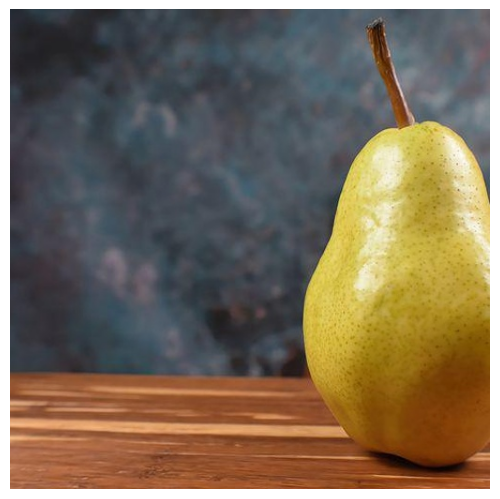

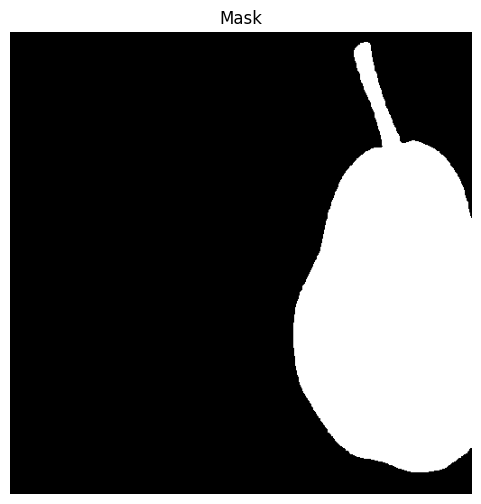

In [70]:
"""
SEGMENT MASKS & SRC INPAINT
"""

# dst_dir_path_gen = osp.join(dst_base,"Gen_results/")

# # data = load_json("/data/Hszhu/dataset/PIE-Bench_v1/Subset_0/coarse_input_full_pack_0.json")
data = load_json("/data/Hszhu/dataset/Geo-Bench/annotations.json")
# # data = load_json("/data/Hszhu/dataset/PIE-Bench_v1/Subset_0/coarse_input_full_pack_0.json")
da_n = random.choice(list(data.keys()))
da_n='182'
da = data[da_n]
instances = da['instances']
ins_id = random.choice(list(instances.keys()))
ins_id = '0'
edit_meta = instances[ins_id]
edit_id = random.choice(list(edit_meta.keys()))
coarse_input_pack = edit_meta[edit_id]
ori_img_path=coarse_input_pack['ori_img_path']
ori_mask_path = coarse_input_pack['ori_mask_path']
print(f'da_n:{da_n} ins_id:{ins_id} edit_id:{edit_id}')

# 
# mask_pool = prepare_mask_pool(instances)
# constrain_areas_strict = get_constrain_areas(mask_pool)
# constrain_areas_strict  = cv2.resize(constrain_areas_strict , dsize=(512,512), interpolation=cv2.INTER_NEAREST)
# ori_img_path ="/data/Hszhu/dataset/partial-editing/imgs/elephant.jpg"
# ori_mask_temp  = "/data/Hszhu/dataset/partial-editing/masks/draw_mask.png"

# ori_mask_temp = "/data/Hszhu/dataset/partial-editing/masks/cat2/mask_5.png"
# ori_mask_path = "/data/Hszhu/dataset/partial-editing/masks/dog_body.png"
# ori_mask_path = "/data/Hszhu/dataset/partial-editing/masks/level2/elephant/mask_full.png"
ori_mask_temp = ori_mask_path
# edit_prompt = coarse_input_pack['edit_prompt']
# edit_param = coarse_input_pack['edit_param']

# ori_img = cv2.imread(coarse_input_pack['ori_img_path'])  # bgr
ori_img = cv2.imread(ori_img_path)
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
ori_img = cv2.resize(ori_img, dsize=(512,512), interpolation=cv2.INTER_LANCZOS4)
# ori_caption  = coarse_input_pack['tag_caption']
# ori_mask = cv2.imread(coarse_input_pack['ori_mask_path'])
ori_mask = cv2.imread(ori_mask_path)
# obj_label = coarse_input_pack['obj_label']

# target_mask = cv2.imread(coarse_input_pack['tgt_mask_path'])

# ddpm_region_mask =  cv2.imread(coarse_input_pack['ddpm_region_path'])
# coarse_input = cv2.imread(coarse_input_pack['coarse_input_path'])  # bgr
# coarse_input = cv2.cvtColor( coarse_input , cv2.COLOR_BGR2RGB)
# temp_view_img(coarse_input)
ori_mask = cv2.resize(ori_mask, dsize=ori_img.shape[:2], interpolation=cv2.INTER_NEAREST)
dilation_factor = 0
dil_ori_mask = dilate_mask(ori_mask, dilation_factor)
# dil_ori_mask = np.where(forbit_area,0,dil_ori_mask)
Image.fromarray(dil_ori_mask).save('obj_remove_mask.png')
# #re editing 2D for vis
# new_edit_param = [0,0,0,0,0,0,0.4,0.4,1]
# coarse_input,target_mask = re_edit_2d(ori_img,ori_mask,new_edit_param,inp_back_ground)
# save_img_cr = Image.fromarray(coarse_input)
# save_img_cr.save("new_edit_cr.png")
# temp_view_img(coarse_input)
# seed_r = 3787517166  # 3787517166 #4255183641 #4255183641 #2391550765
temp_view_img(ori_img)
temp_view(ori_mask)

Global seed set to 1725123210
DDIM Sampler: 100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


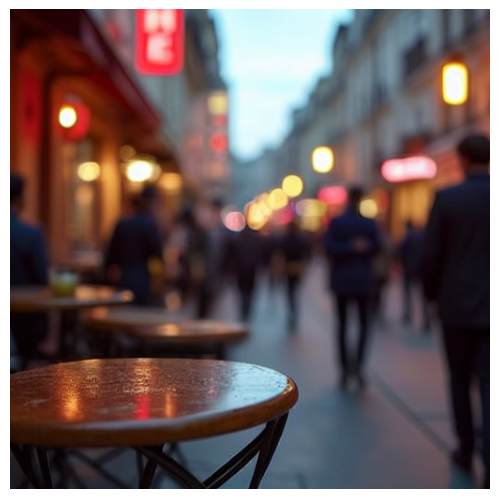

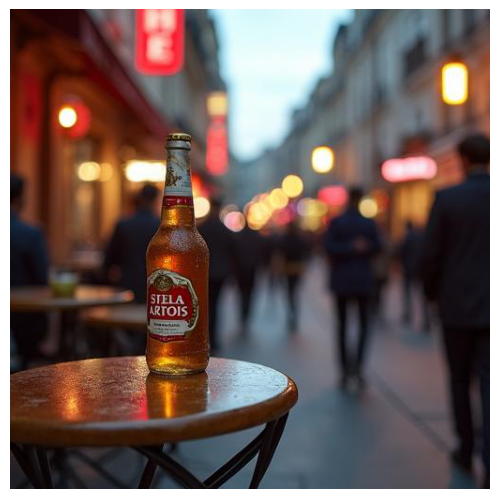

In [57]:

seed_r = random.randint(0, 10 ** 16)
# seed_r  = 3308404718
# seed_r = 4212076026
# seed_r = 3335266080
# seed_r= 2815518441
seed_r = 1725123210
controller = Attention_Modulator()
model.controller = controller
register_attention_control_4bggen(model, controller)
model.modify_unet_forward()
model.enable_attention_slicing()
model.enable_xformers_memory_efficient_attention()
generated_results = model.FreeFine_background_generation(ori_img, dil_ori_mask, "empty scene ", guidance_scale=5,
                                                         eta=1.0, end_step=50, num_step=50, end_scale=0.0,
                                                         start_step=1, share_attn=True, method_type='caa',
                                                         local_text_edit=True,
                                                         local_ddpm=True, verbose=True,
                                                         seed=seed_r,
                                                         return_intermediates=False,
                                                         )  # add gen_res in input_pack
inp_back_ground = generated_results
# temp_view_img(ori_img)
temp_view_img(generated_results)
save_img = Image.fromarray(generated_results)
save_img.save("generated_results.png")
  #TODO: BLENDING
blended = False
ori_mask_path   = ori_mask_temp
ori_mask = cv2.imread(ori_mask_path)
ori_mask = cv2.resize(ori_mask, dsize=ori_img.shape[:2], interpolation=cv2.INTER_NEAREST)

if blended:
    # TODO, assert ndarray

    # blur, you can adjust the parameters for better performance
    mask_blurred = cv2.GaussianBlur(ori_mask, (1, 1), 0) / 255
    mask_np = 1 - (1 - ori_mask) * (1 - mask_blurred)
    image_pasted = ori_img * (1 - mask_np) + generated_results * mask_np
    image_pasted = image_pasted.astype(generated_results.dtype)
    temp_view_img(image_pasted)
    inp_back_ground = image_pasted

Image.fromarray(generated_results).save("/data/Hszhu/dataset/temp/inp_img.png")
temp_view_img(ori_img)


In [ ]:
import gradio as gr
import numpy as np
import cv2
from PIL import Image
import json


def process_drawing(drawing):
    # 将绘制的图像转换为灰度图像
    mask = drawing["mask"].convert("L")
    # 将灰度图像转换为numpy数组
    mask_array = np.asarray(mask)
    # 将灰度值大于128的区域设为1，其余为0
    mask_array = np.where(mask_array > 128, 1, 0).astype(np.uint8)

    # 创建单通道掩膜图像并保存，确保是L模式（单通道灰度图）
    mask_image = Image.fromarray(mask_array * 255, mode="L")  # 使用 "L" 模式来确保单通道
    save_path = "/data/Hszhu/dataset/partial-editing/masks/draw_mask.png"
    mask_image.save(save_path)  # 保存为PNG格式（单通道）

    # 返回处理后的掩膜图像（单通道）
    return mask_image


def create_ui(image_path):
    with gr.Blocks() as demo:  # 显示原始图像
        # 创建绘图区域，启用图像编辑
        drawing = gr.Image(value=image_path, label="Draw the Mask", type="pil", interactive=True, tool="sketch",
                           height=512, width=512, brush_color='#FFFFFF', mask_opacity=0.5, brush_radius=30)

        # 创建保存按钮
        save_button = gr.Button("Process")

        # 定义保存按钮的行为：处理绘制的图像
        save_button.click(process_drawing, inputs=[drawing], outputs=[gr.Image(type="pil", label="Processed Mask")])

    return demo




# 创建并启动 Gradio UI
ui = create_ui(ori_img_path )
ui.launch()


In [ ]:
mask_1 = cv2.imread("/data/Hszhu/dataset/partial-editing/masks/level2/elephant/mask_1.png")
mask_2 = cv2.imread("/data/Hszhu/dataset/partial-editing/masks/level2/elephant/mask_3.png")
mask_2 = dilate_mask(mask_2,2)
mask_1[mask_1>0] = 1
mask_2[mask_2>0] = 1
mask = mask_1 + mask_2
mask[mask>0] = 255
cv2.imwrite("/data/Hszhu/dataset/partial-editing/masks/level2/elephant/mask_full.png",mask)
temp_view(mask)

da_n521 ins_id0 edit_id5


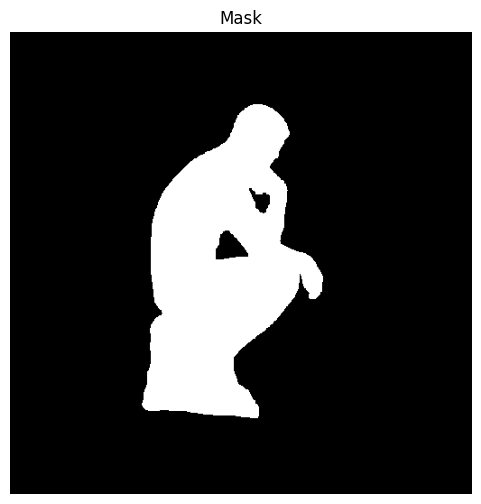

In [71]:


def re_compose(app_img, app_mask, edit_param, bg_img, ori_mask=None):
    # if ori_mask is given, align mask center
    if len(app_mask.shape) == 3:
        app_mask = app_mask[:, :, 0]

    # Convert ori_mask to 2D if needed
    if ori_mask is not None and len(ori_mask.shape) == 3:
        ori_mask = ori_mask[:, :, 0]

    dx, dy, dz, rx, ry, rz, sx, sy, sz = edit_param
    rotation_angle = rz
    resize_scale = (sx, sy)
    flip_horizontal = False
    flip_vertical = False

    # Prepare foreground
    height, width = app_mask.shape[:2]

    # Calculate app_mask center
    y_indices, x_indices = np.where(app_mask)
    if len(y_indices) == 0 or len(x_indices) == 0:
        # No mask pixels found
        return bg_img, np.zeros_like(app_mask)

    top, bottom = np.min(y_indices), np.max(y_indices)
    left, right = np.min(x_indices), np.max(x_indices)
    mask_center_x, mask_center_y = (right + left) / 2, (top + bottom) / 2

    # If ori_mask is provided, calculate its center and compute offset
    if ori_mask is not None:
        ori_y_indices, ori_x_indices = np.where(ori_mask)
        if len(ori_y_indices) > 0 and len(ori_x_indices) > 0:
            ori_top, ori_bottom = np.min(ori_y_indices), np.max(ori_y_indices)
            ori_left, ori_right = np.min(ori_x_indices), np.max(ori_x_indices)
            ori_center_x, ori_center_y = (ori_right + ori_left) / 2, (ori_top + ori_bottom) / 2

            # Calculate the offset needed to align centers
            dx += (ori_center_x - mask_center_x)
            dy += (ori_center_y - mask_center_y)

    # Check if movement would take object out of bounds
    if dx != 0 or dy != 0:
        new_left = left + dx
        new_right = right + dx
        new_top = top + dy
        new_bottom = bottom + dy

    # Prepare transformation matrix
    rotation_matrix = cv2.getRotationMatrix2D((mask_center_x, mask_center_y), -rotation_angle, 1)

    # Adjust for scaling
    tx, ty = (1 - resize_scale[0]) * mask_center_x, (1 - resize_scale[1]) * mask_center_y
    dx += tx
    dy += ty

    rotation_matrix[0, 2] += dx
    rotation_matrix[1, 2] += dy
    rotation_matrix[0, 0] *= resize_scale[0]
    rotation_matrix[1, 1] *= resize_scale[1]

    # Apply transformation
    transformed_image = cv2.warpAffine(app_img, rotation_matrix, (width, height))
    transformed_mask = cv2.warpAffine(app_mask.astype(np.uint8), rotation_matrix, (width, height),
                                      flags=cv2.INTER_NEAREST).astype(bool)

    # Compose final image
    final_image = np.where(transformed_mask[:, :, None], transformed_image, bg_img)
    # transformed_mask.astype(np.uint8) * 255

    return final_image,np.stack([transformed_mask.astype(np.uint8)] * 3, axis=-1) * 255

inp_back_ground= ori_img.copy()
# inp_back_ground = cv2.imread("/data/Hszhu/dataset/temp/inp_img.png")
# inp_back_ground = cv2.cvtColor(inp_back_ground, cv2.COLOR_BGR2RGB)

data = load_json("/data/Hszhu/dataset/Geo-Bench/annotations.json")
# # data = load_json("/data/Hszhu/dataset/PIE-Bench_v1/Subset_0/coarse_input_full_pack_0.json")
da_n = random.choice(list(data.keys()))
da_n='521'
da = data[da_n]
instances = da['instances']
ins_id = random.choice(list(instances.keys()))
edit_meta = instances[ins_id]
edit_id = random.choice(list(edit_meta.keys()))
coarse_input_pack = edit_meta[edit_id]
app_img_path=coarse_input_pack['ori_img_path']
app_mask_path = coarse_input_pack['ori_mask_path']
print(f'da_n{da_n} ins_id{ins_id} edit_id{edit_id}')

bg_img = ori_img.copy()
# bg_img = cv2.imread("/data/Hszhu/dataset/partial-editing/imgs/elephant.jpg")
# bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)
# bg_img = cv2.resize(bg_img, dsize=inp_back_ground.shape[:2], interpolation=cv2.INTER_LANCZOS4)
# fg_mask  = cv2.imread("/data/Hszhu/dataset/partial-editing/masks/level2/elephant/mask_full.png")
fg_mask = ori_mask
fg_mask[fg_mask>0] = 1
bg_mask = 1- fg_mask
# bg_mask = np.ones_like(bg_mask)
bg_mask[bg_mask>0] = 255
bg_mask = cv2.resize(bg_mask, dsize=inp_back_ground.shape[:2], interpolation=cv2.INTER_NEAREST)
# app_img = cv2.imread("/data/Hszhu/dataset/partial-editing/imgs/elephant.jpg")

# app_img = cv2.imread("/data/Hszhu/dataset/partial-editing/imgs/girl.jpg")
app_img = cv2.imread(app_img_path)
# app_img = cv2.imread("/data/Hszhu/dataset/temp/coarse_3d_2.png")

app_img = cv2.cvtColor(app_img, cv2.COLOR_BGR2RGB)
app_img = cv2.resize(app_img, dsize=inp_back_ground.shape[:2], interpolation=cv2.INTER_LANCZOS4)
# app_mask = cv2.imread("/data/Hszhu/dataset/partial-editing/masks/level2/elephant/mask_full.png")
# app_mask  = cv2.imread("/data/Hszhu/dataset/partial-editing/masks/girl/mask0.jpg")
app_mask = cv2.imread(app_mask_path)
# app_mask = cv2.imread("/data/Hszhu/dataset/temp/target_mask_3d_2.png")
app_mask = cv2.resize(app_mask, dsize=inp_back_ground.shape[:2], interpolation=cv2.INTER_NEAREST)

# da_n='604'
# da = data[da_n]
# instances = da['instances']
# ins_id = '0'
# edit_meta = instances[ins_id]
# edit_id = random.choice(list(edit_meta.keys()))
# coarse_input_pack = edit_meta[edit_id]
# app_img_path_2=coarse_input_pack['ori_img_path']
# app_mask_path_2 = coarse_input_pack['ori_mask_path']
# print(f'da_n{da_n} ins_id{ins_id} edit_id{edit_id}')
# #
# #
# app_img_2 = cv2.imread(app_img_path_2)
# # app_img = cv2.imread("/data/Hszhu/dataset/temp/coarse_3d_2.png")
#
# app_img_2 = cv2.cvtColor(app_img_2, cv2.COLOR_BGR2RGB)
# app_img_2 = cv2.resize(app_img_2, dsize=inp_back_ground.shape[:2], interpolation=cv2.INTER_LANCZOS4)
# # app_mask = cv2.imread("/data/Hszhu/dataset/partial-editing/masks/level2/elephant/mask_full.png")
# # app_mask  = cv2.imread("/data/Hszhu/dataset/partial-editing/masks/girl/mask0.jpg")
# app_mask_2 = cv2.imread(app_mask_path_2)
# # app_mask = cv2.imread("/data/Hszhu/dataset/temp/target_mask_3d_2.png")
# app_mask_2 = cv2.resize(app_mask_2, dsize=inp_back_ground.shape[:2], interpolation=cv2.INTER_NEAREST)
# #
# #
# #
# da_n='417'
# da = data[da_n]
# instances = da['instances']
# ins_id = '0'
# edit_meta = instances[ins_id]
# edit_id = random.choice(list(edit_meta.keys()))
# coarse_input_pack = edit_meta[edit_id]
# app_img_path_3=coarse_input_pack['ori_img_path']
# app_mask_path_3 = coarse_input_pack['ori_mask_path']
# print(f'da_n{da_n} ins_id{ins_id} edit_id{edit_id}')
#
#
# app_img_3 = cv2.imread(app_img_path_3)
# # app_img = cv2.imread("/data/Hszhu/dataset/temp/coarse_3d_2.png")
#
# app_img_3 = cv2.cvtColor(app_img_3, cv2.COLOR_BGR2RGB)
# app_img_3 = cv2.resize(app_img_3, dsize=inp_back_ground.shape[:2], interpolation=cv2.INTER_LANCZOS4)
# # app_mask = cv2.imread("/data/Hszhu/dataset/partial-editing/masks/level2/elephant/mask_full.png")
# # app_mask  = cv2.imread("/data/Hszhu/dataset/partial-editing/masks/girl/mask0.jpg")
# app_mask_3 = cv2.imread(app_mask_path_3)
# # app_mask = cv2.imread("/data/Hszhu/dataset/temp/target_mask_3d_2.png")
# app_mask_3 = cv2.resize(app_mask_3, dsize=inp_back_ground.shape[:2], interpolation=cv2.INTER_NEAREST)
temp_view(app_mask)
# temp_view(app_mask_2)
# temp_view(app_mask_3)


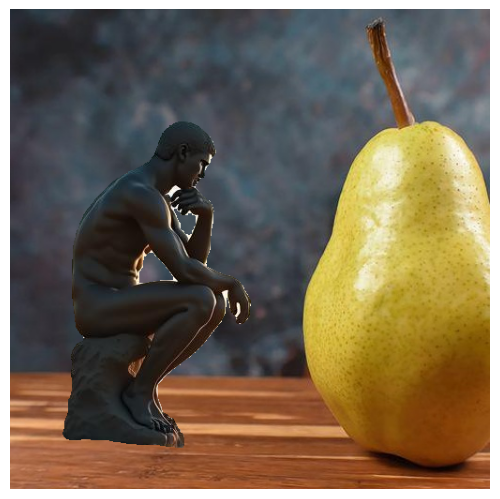

In [72]:
#2D
# edit_param = [20,-30,0,0,0,-30,1,1,1]
# edit_param = [-10,-105,0,0,0,0,0.24,0.24,1]
edit_param = [-90,40,0,0,0,0,1.0,1.0,1]
# edit_param_2 = [-60,20,0,0,0,0,0.5,0.5,1]
# edit_param_3 = [-70,-10,0,0,0,0,0.7,0.7,1]

coarse_input, target_mask = re_compose(app_img,app_mask ,edit_param, inp_back_ground)
# temp_view(target_mask)?
# temp_view(app_mask_2)
# coarse_input, target_mask_2 = re_compose(app_img_2,app_mask_2 ,edit_param_2, coarse_input)
# coarse_input, target_mask_3 = re_compose(app_img_3,app_mask_3 ,edit_param_3, coarse_input)
# temp_view_img(ori_img_3d)
temp_view_img(coarse_input)
save_img = Image.fromarray(target_mask)
save_img.save("/data/Hszhu/dataset/temp/tgt_mask.png")
save_img = Image.fromarray(coarse_input)
save_img.save("/data/Hszhu/dataset/temp/coarse_input.png")


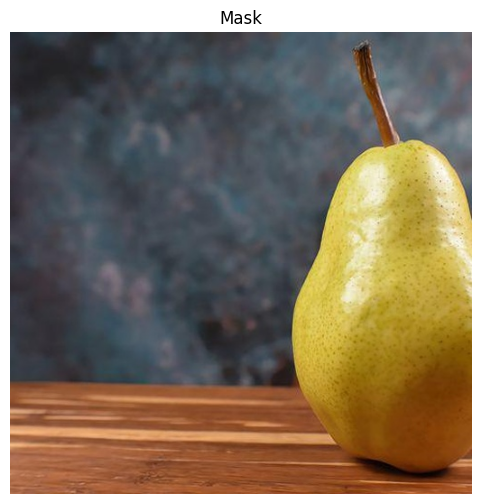

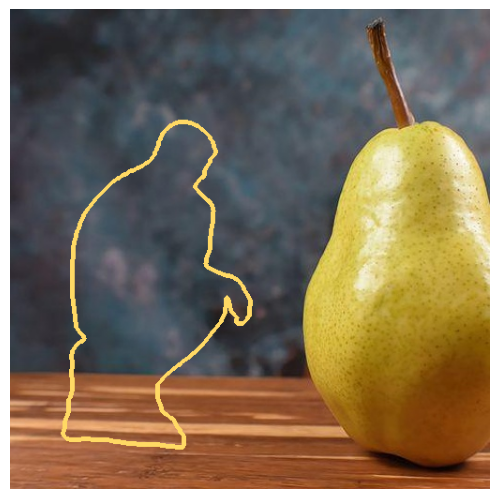

In [96]:

# Image.fromarray(trans_hole_image).save("/data/Hszhu/dataset/tower/coarse_hole_result.png")
# Image.fromarray(coarse_input).save("/data/Hszhu/dataset/tower/coarse_result.png")
# Image.fromarray(target_mask).save("/data/Hszhu/dataset/tower/target_mask.png")
# save_img = Image.fromarray(target_mask)
# save_img.save("/data/Hszhu/dataset/temp/tgt_mask.png")
def edit_demo():
    darken_factor = 0.5
    # image = cv2.cvtColor(cv2.imread(ori_img_path),cv2.COLOR_BGR2RGB)
    image = bg_img.copy()
    # image = cv2.cvtColor(cv2.imread("/data/Hszhu/dataset/temp/inp_img.png"),cv2.COLOR_BGR2RGB)
    mask = cv2.resize(cv2.imread(f"/data/Hszhu/dataset/temp/tgt_mask.png", cv2.IMREAD_GRAYSCALE), (image.shape[1],image.shape[0]))
    omask = cv2.resize(cv2.imread(ori_mask_path, cv2.IMREAD_GRAYSCALE), (image.shape[1],image.shape[0], ))
    
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    _, omask = cv2.threshold(omask, 127, 255, cv2.THRESH_BINARY)
    # image[omask == 255] = (image[omask == 255] * darken_factor).astype(np.uint8)
    
    # if os.path.exists(draw_mask_path):
    #     draw_mask = cv2.resize(cv2.imread(draw_mask_path, cv2.IMREAD_GRAYSCALE), (image.shape[0], image.shape[1]))
    #     _, draw_mask = cv2.threshold(draw_mask, 127, 255, cv2.THRESH_BINARY)
    #     color_layer = image.copy()
    #     # (102, 217, 255) (190, 251, 183)
    #     color_layer[draw_mask == 255] = (141, 208, 168)
    #     a = 0.5
    #     image = cv2.addWeighted(image, 1-a, color_layer, a, 0)
    
    ocontours, _ = cv2.findContours(omask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # cv2.drawContours(image, ocontours, -1, (255, 255, 255), thickness=3)
    cv2.drawContours(image, contours, -1, (255, 217, 100), thickness=3)
    
    # cv2.imshow("Contour on Image", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()save_img.save("/data/Hszhu/dataset/temp/TEMP.png")
    cv2.imwrite(f"/data/Hszhu/dataset/temp/VIS2.png",cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # if os.path.exists(draw_mask_path):
    #     draw_mask = cv2.resize(cv2.imread(draw_mask_path, cv2.IMREAD_GRAYSCALE), (image.shape[1],image.shape[0], ))
    #     draw_mask = dilate_mask(draw_mask,30)
    #     _, draw_mask = cv2.threshold(draw_mask, 127, 255, cv2.THRESH_BINARY)
    #     color_layer = image.copy()
    #     # (102, 217, 255) (190, 251, 183)
    #     color_layer[draw_mask == 255] = (255, 255, 0)
    #     a = 0.5
    #     image = cv2.addWeighted(image, 1-a, color_layer, a, 0)

    temp_view_img(image)

    # Image.fromarray(image).save("/data/Hszhu/dataset/Geo-Bench-SC/vis_Dir/sun_2.png")  # 保存为PNG格式（单通道
# edit_demo()
temp_view(ori_img)
def edit_demo_app_trans():
    darken_factor = 0.5
    # image = cv2.cvtColor(cv2.imread(ori_img_path),cv2.COLOR_BGR2RGB)
    image = bg_img.copy()
    # image = cv2.cvtColor(cv2.imread("/data/Hszhu/dataset/temp/inp_img.png"),cv2.COLOR_BGR2RGB)
    mask = cv2.resize(cv2.imread(f"/data/Hszhu/dataset/temp/tgt_mask.png", cv2.IMREAD_GRAYSCALE), (image.shape[1],image.shape[0]))
    omask = cv2.resize(cv2.imread(ori_mask_path, cv2.IMREAD_GRAYSCALE), (image.shape[1],image.shape[0], ))
    
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    _, omask = cv2.threshold(omask, 127, 255, cv2.THRESH_BINARY)
    # image[omask == 255] = (image[omask == 255] * darken_factor).astype(np.uint8)
    
    # if os.path.exists(draw_mask_path):
    #     draw_mask = cv2.resize(cv2.imread(draw_mask_path, cv2.IMREAD_GRAYSCALE), (image.shape[0], image.shape[1]))
    #     _, draw_mask = cv2.threshold(draw_mask, 127, 255, cv2.THRESH_BINARY)
    #     color_layer = image.copy()
    #     # (102, 217, 255) (190, 251, 183)
    #     color_layer[draw_mask == 255] = (141, 208, 168)
    #     a = 0.5
    #     image = cv2.addWeighted(image, 1-a, color_layer, a, 0)
    
    ocontours, _ = cv2.findContours(omask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # cv2.drawContours(image, ocontours, -1, (255, 255, 255), thickness=3)
    cv2.drawContours(image, contours, -1, (255, 217, 100), thickness=3)
    
    # cv2.imshow("Contour on Image", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()save_img.save("/data/Hszhu/dataset/temp/TEMP.png")
    cv2.imwrite(f"/data/Hszhu/dataset/temp/VIS3.png",cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # if os.path.exists(draw_mask_path):
    #     draw_mask = cv2.resize(cv2.imread(draw_mask_path, cv2.IMREAD_GRAYSCALE), (image.shape[1],image.shape[0], ))
    #     draw_mask = dilate_mask(draw_mask,30)
    #     _, draw_mask = cv2.threshold(draw_mask, 127, 255, cv2.THRESH_BINARY)
    #     color_layer = image.copy()
    #     # (102, 217, 255) (190, 251, 183)
    #     color_layer[draw_mask == 255] = (255, 255, 0)
    #     a = 0.5
    #     image = cv2.addWeighted(image, 1-a, color_layer, a, 0)

    temp_view_img(image)

edit_demo_app_trans()

In [40]:
import gradio as gr
import numpy as np
import cv2
from PIL import Image
import json
def process_drawing(drawing):
    # 将绘制的图像转换为灰度图像
    mask = drawing["mask"].convert("L")
    # 将灰度图像转换为numpy数组
    mask_array = np.asarray(mask)
    # 将灰度值大于128的区域设为1，其余为0
    mask_array = np.where(mask_array > 128, 1, 0).astype(np.uint8)

    # 创建单通道掩膜图像并保存，确保是L模式（单通道灰度图）
    mask_image = Image.fromarray(mask_array * 255, mode="L")  # 使用 "L" 模式来确保单通道
    save_path = "/data/Hszhu/dataset/temp/draw_mask.png"
    mask_image.save(save_path)  # 保存为PNG格式（单通道）

    # 返回处理后的掩膜图像（单通道）
    return mask_image



def create_ui(image_path):
    with gr.Blocks() as demo: # 显示原始图像
        # 创建绘图区域，启用图像编辑
        drawing = gr.Image(value=image_path, label="Draw the Mask", type="pil", interactive=True, tool="sketch",height=512, width=512,brush_color='#FFFFFF', mask_opacity=0.5, brush_radius=30)

        # 创建保存按钮
        save_button = gr.Button("Process")

        # 定义保存按钮的行为：处理绘制的图像
        save_button.click(process_drawing, inputs=[drawing], outputs=[gr.Image(type="pil", label="Processed Mask")])


    return demo
# image_path = app_img_path
image_path = coarse_input
# 创建并启动 Gradio UI
ui = create_ui(image_path)
ui.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Global seed set to 2763175462


current type is caa


DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  8.48it/s] 


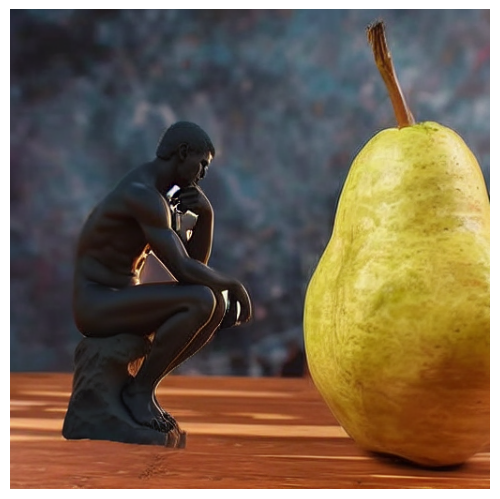

In [92]:

controller = Attention_Modulator(start_layer=10)
model.controller = controller
register_attention_control_compose(model, controller)
model.modify_unet_forward()
model.enable_attention_slicing()
model.enable_xformers_memory_efficient_attention()
draw_mask = cv2.imread("/data/Hszhu/dataset/temp/draw_mask.png")
seed_r = random.randint(0, 10 ** 16)
# seed_r = 564988249
# seed_r = 1038540904
# seed_r = 4134456677
# seed_r = 4214
# seed_r = 693644810 4257194181
# seed_r = 4257194181
seed_r =2763175462
generated_results = model.FreeFine_cross_image_composition([app_img, bg_img], [app_mask, bg_mask], [target_mask], coarse_input,
                                                           ["bronze statue"], guidance_scale=4.0,
                                                           eta=1.0, end_scale=0.0,
                                                           end_step=50, num_step=50,
                                                           start_step=25, share_attn=True, method_type='caa',
                                                           local_text_edit=True, draw_mask=None,
                                                           local_ddpm=True, verbose=True,
                                                           seed=seed_r, dil_completion=True, dil_factor=15, appearance_transfer=False,
                                                           )  # add gen_res in input_pack
# seed_r = 2021134420
# generated_results = model.cross_image_composition([app_img,bg_img], [app_mask,bg_mask],[ori_mask], ori_img,
#                                                    ["cake"], guidance_scale=7.5,
#                                                    eta=1.0,end_scale=0.7,
#                                                    end_step=50, num_step=50,
#                                                    start_step=5, share_attn=True,method_type='caa',
#                                                    local_text_edit=True,draw_mask=None,
#                                                    local_perturbation=True, verbose=True,
#                                                    seed=seed_r,dil_completion=False,dil_factor=10,appearance_transfer=True,
#                                                    )  # add gen_res in input_pack
temp_view_img(generated_results)
save_img = Image.fromarray(generated_results)
save_img.save("/data/Hszhu/dataset/temp/generated_results.png")
# temp_view_img(draw_mask)

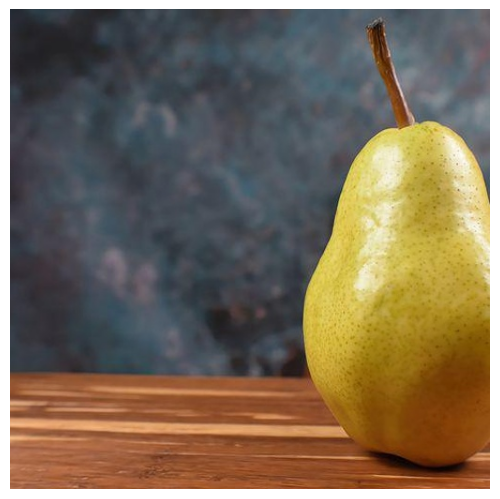

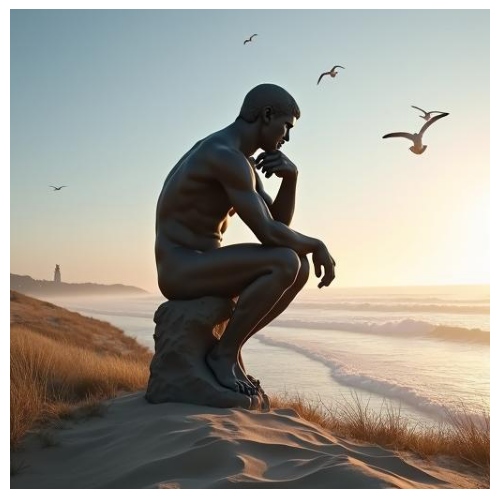

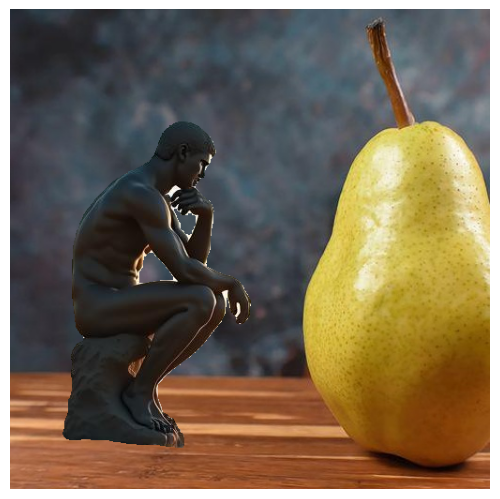

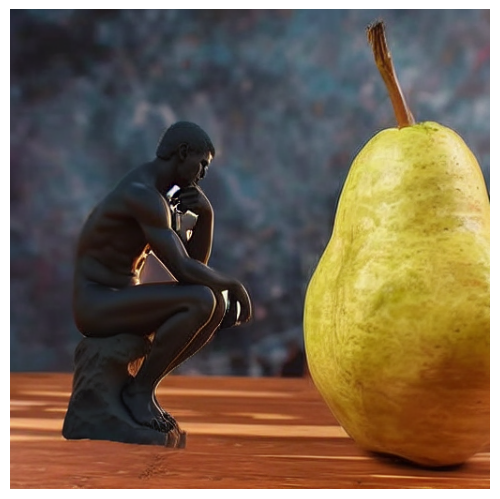

In [93]:
temp_view_img(ori_img)
temp_view_img(app_img)
# temp_view_img(app_img_2)
# temp_view_img(app_img_3)
temp_view_img(coarse_input)
temp_view_img(generated_results)
save_img = Image.fromarray(generated_results)
save_img.save("/data/Hszhu/dataset/temp/generated_results.png")


In [ ]:
temp_view(bg_mask)